In [1]:
import pandas as pd
from sklearn.metrics import  f1_score
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from IPython.display import clear_output

from app import cat_features, pca_pipeline, lag_features

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
pd.set_option('display.max_columns', None) 

In [3]:
data = pd.read_csv('df_general.csv')
data[lag_features] = data[lag_features].fillna(999)

In [4]:
data.fillna(0, inplace=True)

In [5]:
train = data[data['gameweek_compSeason_label'] != 2023]
test = data[data['gameweek_compSeason_label'] == 2023]

In [6]:
X_train = train.drop('team_1_hue', axis=1)
y_train = train['team_1_hue']

cat_cols = cat_features(X_train)
num_cols = list(set(X_train.columns.tolist()) - set(cat_cols))

X_test = test.drop('team_1_hue', axis=1)
y_test = test['team_1_hue']

In [7]:
X_train.shape, X_test.shape

((3192, 1196), (180, 1196))

In [8]:
X_train, pipeline = pca_pipeline(X_train, y_train, cat_cols, num_cols, n_components=20 ,pca=True)

In [9]:
X_train

array([[-4.95875494e+02,  1.69138819e+03,  2.38560137e+03, ...,
        -1.27471323e+00,  2.04870731e+00,  2.26456224e+00],
       [-4.98870888e+02,  1.69123660e+03,  2.38553617e+03, ...,
        -5.44389863e-01,  1.27947120e+00,  4.44591672e-01],
       [-5.05859976e+02,  1.69087925e+03,  2.38538623e+03, ...,
        -1.17791357e+00,  1.70228895e+00,  1.88161821e+00],
       ...,
       [-3.43226620e+02, -4.80789947e+02,  5.60825882e+01, ...,
         4.14720304e+00, -5.42350444e-01,  1.15166748e+00],
       [-3.50245398e+02, -4.80453779e+02,  5.55917029e+01, ...,
         4.61620294e+00,  3.97256922e+00, -6.49946449e-01],
       [-3.44123843e+02, -4.82599221e+02,  5.52085877e+01, ...,
         4.02004220e+00,  9.40782284e-01, -8.78503730e-01]])

In [10]:
X_test = pipeline.transform(X_test)
X_test

array([[-3.45137579e+02, -4.82391819e+02,  5.59594314e+01, ...,
         5.33318691e+00,  4.82567474e+00,  6.40909607e-01],
       [-3.60759562e+02,  1.82420465e+02, -3.40748442e+02, ...,
         5.65348667e+00, -3.75154874e-01,  3.91975309e+00],
       [ 5.20512963e+02, -4.38428455e+02,  7.36834395e+01, ...,
         3.61825925e+00, -1.05897938e+00,  2.65037482e-01],
       ...,
       [-3.45208932e+02, -4.80275101e+02,  5.47686833e+01, ...,
         5.84444412e+00,  1.03774637e+00,  3.85059260e+00],
       [-3.61172030e+02, -4.82118446e+02,  5.51560787e+01, ...,
         4.88887201e+00,  5.95944925e-02, -1.63057364e-01],
       [ 1.60765173e+03, -3.81253600e+02,  9.92142973e+01, ...,
         3.56221913e+00,  1.37600283e+00,  2.86611206e+00]])

In [11]:
X_train.shape, X_test.shape

((3192, 20), (180, 20))

In [12]:
!nvidia-smi

Sun Jun  2 16:42:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:0A:00.0  On |                  N/A |
|  0%   50C    P2             61W /  285W |   14525MiB /  16376MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('MSE')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True, device='cuda'):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training Accuracy over the last epoch
      - val_mse: validation Accuracy after the last epoch
    '''
    torch.manual_seed(42)
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    for epoch in range(1, num_epochs + 1):
        model.train()

        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'Accuracy': metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
                
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'Accuracy': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f'Validation Accuracy: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]

In [14]:
class BaseLineModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaseLineModel, self).__init__()
        # Первый слой
        self.block1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Второй слой
        self.block2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Третий слой
        self.block3 = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.BatchNorm1d(input_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Четвертый слой
        self.block4 = nn.Sequential(
            nn.Linear(input_size, input_size//4),
            nn.BatchNorm1d(input_size//4),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Выход
        self.output_block = nn.Sequential(
            nn.Linear(input_size//4, output_size),
            nn.BatchNorm1d(output_size),
            nn.Softmax(dim=1)  
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.output_block(out)
        return out

In [15]:
input_size = X_train.shape[1]
hidden_size = input_size * 4
output_size = 3
batch_size = 256
num_epochs = 80

In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(list(y_train), dtype=torch.int16)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(list(y_test), dtype=torch.int16)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BaseLineModel(input_size, hidden_size, output_size).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
metric = lambda outputs, targets: (outputs.argmax(dim=1) == targets).float().mean().item()

In [18]:
for X_batch, y_batch in train_loader:   
    X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
    pred = model(X_batch)
    loss = criterion(pred, y_batch)
    print(loss)
    break


tensor(1.1105, device='cuda:0', grad_fn=<NllLossBackward0>)


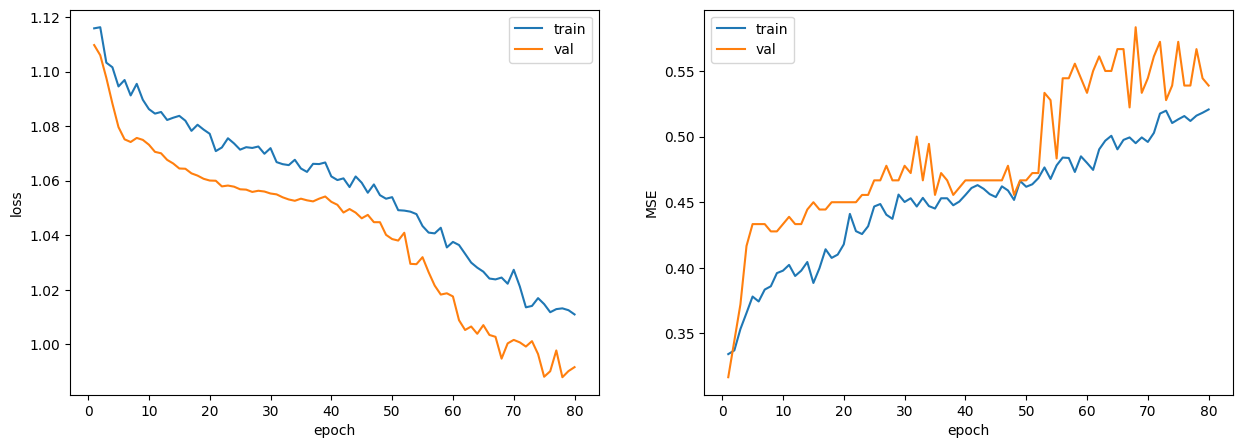

Validation Accuracy: 0.539


In [19]:
train_acc, val_acc = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                                         num_epochs=num_epochs, verbose=True, device=device)

In [20]:
f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='weighted')

0.4826602370906168